<img width="10%" alt="Naas" src="https://landen.imgix.net/jtci2pxwjczr/assets/5ice39g4.png?w=160"/>

# Azure Machine Learning - Univariate Timeseries Inference

**Tags:** #azure #machinelearning #univariate #timeseries #inference #ml

**Author:** [Tobias Zwingmann](https://www.linkedin.com/in/tobias-zwingmann/)

**Description:** This notebook provides an example of how to use Azure Machine Learning to perform univariate timeseries inference. It is useful for organizations that need to analyze and predict future trends in their data.

Requires a timeseries forecasting model hosted on Microsoft Azure and deployed as a web service. (See references below).

**References:**
- [Azure Machine Learning Documentation](https://docs.microsoft.com/en-us/azure/machine-learning/)
- [Tutorial: Forecast demand with no-code automated machine learning in the Azure Machine Learning studio](https://learn.microsoft.com/en-us/azure/machine-learning/tutorial-automated-ml-forecast)
- [Univariate Timeseries Inference](https://en.wikipedia.org/wiki/Time_series#Univariate_time_series_models)

## Input

### Import libraries

In [1]:
import pandas as pd
import requests
import json

### Setup Variables
- `timestamp_col`: The name of the column with the timestamps. Must be the same as used in training.
- `timestamps_to_predict`: A list of the timestamps to predict. The timestamps must lie **after** the timestamps observed during training
- `api_url`: the http URL to the Azure forecasting model
- `api_key`: the access key for the model

In [26]:
timestamp_col = "timeStamp"

timestamps_to_predict = ["2017-08-10 06:00:00", 
                      "2017-08-10 07:00:00",
                      "2017-08-10 08:00:00",
                      "2017-08-10 09:00:00",
                      "2017-08-10 10:00:00",
                      "2017-08-10 11:00:00"]

# Azure hosted model URL and key
api_url = "http://d179457c-d475-48f6-a5c4-f1f9f560ca1f.eastus2.azurecontainer.io/score"
api_key = "bnDjGh7cQ7jPgsnSjshhTvIsmr1Ksmt1"

In [33]:
# Historic data - adjust if needed for plotting
data = pd.DataFrame({timestamp_col: ["2017-08-10 01:00:00", 
                      "2017-08-10 02:00:00",
                      "2017-08-10 03:00:00",
                      "2017-08-10 04:00:00",
                      "2017-08-10 05:00:00", 
                      "2017-08-10 06:00:00"],
                     "values": [6053.458, 6714.258, 6497.025, 6360.583, 6333.775, 6534.683]})

## Model

### Perform Univariate Timeseries Inference

Using the forecasting model, perform univariate timeseries inference on the data.

In [28]:
def inference_request(timestamp_col, timestamps):
  # Bind columns to dataframe
  request_df = pd.DataFrame({timestamp_col: timestamps})
  
  req = {
      "Inputs": {
          "data": list(request_df.to_dict('records'))
          },
         "GlobalParameters": {
             "quantiles": [0.025,0.975]
             }
         }
        
  # POST request - send JSON to API
  headers = {'Authorization': ("Bearer " + api_key), 
             'Content-Type': 'application/json'}
  result = requests.post(api_url, data = str.encode(json.dumps(req)), headers=headers)
  return(result)

def format_timestamps(timestamps):
  # Format timestamp according to Azure requirements
  return(pd.to_datetime(pd.Series(timestamps_to_predict)).dt.strftime("%Y-%m-%dT%H:%M:%S.%fZ"))


# Get predictions
result = inference_request(timestamp_col, format_timestamps(timestamps_to_predict))
result = json.loads(result.content)

# Convert result to dataframe
results_df = pd.DataFrame(result['Results'])

# Move prediction intervals to separate columns
lower = []
upper = []
for element in results_df['prediction_interval']:
  lower.append(json.loads(element)[0])
  upper.append(json.loads(element)[1])

results_df['prediction_interval_lower'] = lower
results_df['prediction_interval_upper'] = upper
results_df['forecast'] = results_df['forecast']
results_df[timestamp_col] = timestamps_to_predict
results_df = results_df.drop("index", axis = 1)
results_df = results_df.drop("prediction_interval", axis = 1)

## Output

### Return predictions only

In [34]:
results_df

,forecast,prediction_interval_lower,prediction_interval_upper,timeStamp
0,6534.259600,5800.307383,7268.211818,2017-08-10 06:00:00
1,6961.366294,5923.401114,7999.331474,2017-08-10 07:00:00
2,7383.259057,6112.016526,8654.501588,2017-08-10 08:00:00
3,7708.796954,6240.892519,9176.701389,2017-08-10 09:00:00
4,7897.971519,6256.804468,9539.138569,2017-08-10 10:00:00
5,7976.711242,6178.902814,9774.519670,2017-08-10 11:00:00


### Return historic data and predictions

In [35]:
data = pd.concat([data, results_df])
data

,timeStamp,values,forecast,prediction_interval_lower,prediction_interval_upper
0,2017-08-10 01:00:00,6053.458,NaN,NaN,NaN
1,2017-08-10 02:00:00,6714.258,NaN,NaN,NaN
2,2017-08-10 03:00:00,6497.025,NaN,NaN,NaN
3,2017-08-10 04:00:00,6360.583,NaN,NaN,NaN
4,2017-08-10 05:00:00,6333.775,NaN,NaN,NaN
5,2017-08-10 06:00:00,6534.683,NaN,NaN,NaN
0,2017-08-10 06:00:00,NaN,6534.259600,5800.307383,7268.211818
1,2017-08-10 07:00:00,NaN,6961.366294,5923.401114,7999.331474
2,2017-08-10 08:00:00,NaN,7383.259057,6112.016526,8654.501588
3,2017-08-10 09:00:00,NaN,7708.796954,6240.892519,9176.701389


### Display Result

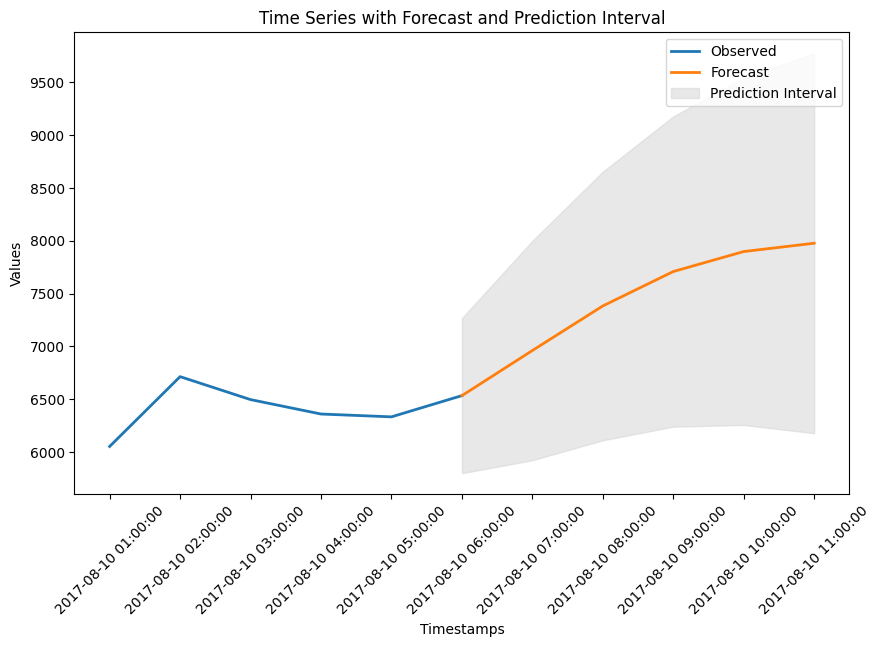

In [36]:
# Plot the original data and the inference data
import matplotlib.pyplot as plt

timestamps = data[timestamp_col]
observed_values = data["values"]
forecast_values = data["forecast"]
lower = data['prediction_interval_lower']
upper = data['prediction_interval_upper']

plt.figure(figsize=(10, 6))
plt.plot(timestamps, observed_values, label='Observed', linewidth=2)
plt.plot(timestamps, forecast_values, label='Forecast', linewidth=2)

plt.fill_between(timestamps, lower, upper, color='lightgray', alpha=0.5, label='Prediction Interval')

plt.xlabel('Timestamps')
plt.ylabel('Values')
plt.title('Time Series with Forecast and Prediction Interval')
plt.legend()
plt.xticks(rotation = 45)
plt.show()